In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [2]:
series = read_csv('../data/single bill for cluster 0.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values

In [3]:
series2 = read_csv('../data/single bill for cluster 1.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values2 = series2.values

In [4]:
series3 = read_csv('../data/single bill for cluster 2.csv .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values3 = series3.values

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### For Cluster 0

In [8]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 858us/step


array([[ 0.01609214],
       [-0.47961634],
       [ 0.4583376 ],
       [-0.12237196],
       [ 0.39432132],
       [-0.27796385],
       [ 0.3858015 ],
       [ 0.24702139],
       [-0.43686014],
       [-0.45204508],
       [ 0.25728488],
       [-0.25736117],
       [ 0.5270452 ],
       [-0.09298088],
       [ 0.3667968 ],
       [-0.31809783],
       [-0.2573576 ],
       [-0.09243095],
       [ 0.57932395],
       [-0.0104472 ],
       [-0.40670007],
       [ 0.47517818],
       [-0.10477432],
       [ 0.5330228 ],
       [ 0.01494291],
       [-0.19130935],
       [ 0.5251537 ],
       [-0.11424068],
       [ 0.01023619],
       [-0.3393088 ],
       [ 0.25277585],
       [ 0.01314284],
       [ 0.43652958],
       [-0.08248802],
       [-0.55266756],
       [ 0.47197205],
       [-0.0054066 ],
       [-0.37666672],
       [ 0.3293695 ],
       [-0.30409843],
       [ 0.51989496],
       [-0.08982477],
       [ 0.4553318 ],
       [-0.20790648]], dtype=float32)

In [9]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=1488.042601, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1323.689634, Expected=1324.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=2007.725082, Expected=1050.000000


Test RMSE: 658.368


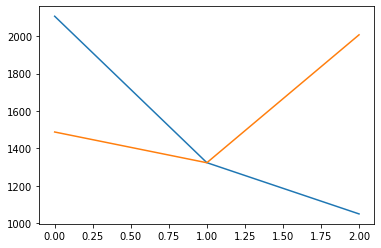

In [10]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [11]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.2558072 ],
       [-0.50641966],
       [ 0.1341067 ],
       [-0.54954416],
       [-0.27244407],
       [ 0.25613543],
       [-0.5754184 ],
       [ 0.08047296],
       [ 0.12316874],
       [-0.13129833],
       [-0.7157563 ],
       [-0.29542768],
       [ 0.06571903],
       [ 0.00682738],
       [-0.18350893],
       [ 0.3896042 ],
       [-0.3376048 ],
       [-0.35054708],
       [ 0.2723023 ],
       [-0.02761487],
       [-0.13853067],
       [ 0.24796513],
       [-0.10276044],
       [ 0.16022485],
       [-0.39529535],
       [ 0.22724539],
       [-0.23699337],
       [-0.42563856],
       [-0.512869  ],
       [ 0.10204863],
       [ 0.4630987 ],
       [-0.3759084 ],
       [-0.5218275 ],
       [ 0.06453827],
       [ 0.5145907 ],
       [-0.44666088],
       [ 0.15857807],
       [-0.01599659],
       [ 0.46537107],
       [ 0.33728608],
       [-0.07546838],
       [ 0.37786084],
       [ 0.59568036],
       [ 0.51005465]], dtype=float32)

In [12]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 15ms/step
Month=1, Predicted=312.660242, Expected=53.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=153.751635, Expected=185.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=129.294659, Expected=52.000000


Test RMSE: 157.453


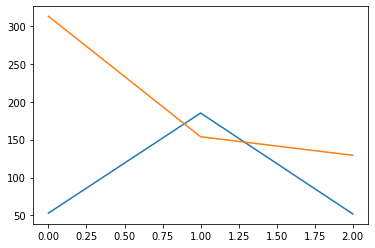

In [13]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [14]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[-0.05961872],
       [-0.40726665],
       [-0.20813888],
       [-0.624427  ],
       [-0.12854679],
       [ 0.01650854],
       [-0.25007263],
       [-0.01589792],
       [ 0.14842954],
       [-0.38117388],
       [ 0.36250076],
       [ 0.15375064],
       [-0.4284647 ],
       [-0.19919032],
       [-0.15528327],
       [-0.39283302],
       [ 0.35007468],
       [-0.67478967],
       [ 0.20623456],
       [-0.22645941],
       [ 0.34960952],
       [-0.03710324],
       [-0.62547565],
       [-0.3061044 ],
       [ 0.20250182],
       [ 0.5822322 ],
       [ 0.50047785],
       [-0.3573464 ],
       [ 0.11111782],
       [ 0.02658044],
       [-0.0804676 ],
       [ 0.16034168],
       [ 0.31468898],
       [ 0.01472968],
       [-0.31066847],
       [ 0.28952292],
       [-0.09925421],
       [-0.00442123],
       [-0.42254123],
       [ 0.15405001],
       [-0.18218337],
       [ 0.03662607],
       [ 0.389393  ],
       [-0.00522983]], dtype=float32)

In [15]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 20ms/step
Month=1, Predicted=2910.312880, Expected=2889.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2951.280770, Expected=2209.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=2809.722590, Expected=2589.000000


Test RMSE: 447.271


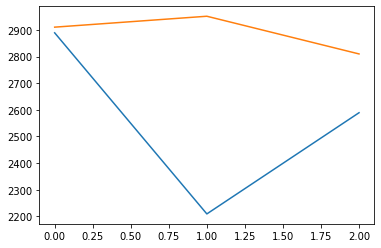

In [16]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()